# Frequency, Time Sweep Program

This program runs frequency, and pulse time sweep on FPGA.

## Get Pyro SoC Instance

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.averager_program import QickSweep, merge_sweeps
from qick.asm_v1 import QickRegister
from qick.pyro import make_proxy

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_9e7b8834f47742059e2241b4b43709e7@192.168.2.99:33491


## Program

In [ ]:
RegisterType = ["freq", "time", "phase", "adc_freq"]

MHz = 1
class Sweep_Freq_Time_Exp(RAveragerProgram):
    def initialize(self):
        freq_rf     = self.cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = self.cfg["pulse_time"] + 100       # Readout length
        )
        # Convert RF frequency to DAC DDS register value
        freq_dac    = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )

        # Set DAC DDS
        self.set_pulse_registers(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = 1000,     # Generator amplitude
            length  = self.cfg["duration_start"], # Pulse length
            phrst   = 0         # Generator DDS phase reset
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = self.cfg["pulse_time"], # Readout DDS multiplication length
            phrst   = 0         # Readout DDS phase reset
        )
        self.synci(100)

        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]
        (self.gen_rp, self.gen_mode) = self._gen_regmap[0, "mode"]
        (self.gen_rp, self.gen_phase) = self._gen_regmap[0, "phase"]
        self.rii = 3
        self.regwi(0, self.rii, self.cfg["inner_loop"] - 1)
    def body(self):
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100       # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 50 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all(100)

    def update(self):
        self.mathi(self.ro_rp, self.ro_freq, self.ro_freq,
                   '+', self.freq2reg_adc(self.cfg["step"], 0, 0))
        self.mathi(self.gen_rp, self.gen_freq, self.gen_freq,
                   '+', self.freq2reg(self.cfg["step"], 0, 0))
        self.loopnz(0, self.rii, "LOOP_A")
        self.safe_regwi(self.ro_rp, self.ro_freq,
                        self.freq2reg_adc(self.cfg["start"], 0, 0))
        self.safe_regwi(self.gen_rp, self.gen_freq,
                        self.freq2reg(self.cfg["start"], 0, 0))
        self.regwi(0, self.rii, self.cfg["inner_loop"] - 1)
        self.mathi(self.gen_rp, self.gen_mode, self.gen_mode,
                   '+', self.cfg["duration_step"]) # Set to single mode
        self.label("LOOP_A")
        self.synci(10)

## Execution

In [3]:
cfg = {
    # Experiment Setup
    "reps" : 100,
    "duration_sweep_num" : 10,
    "start" : 500,
    "inner_loop" : 100,
    "step" : 1,
    "duration_start" : 1000,
    "duration_step" : 200,
    "expts" : 5000,
    # Parameter Setup
    "pulse_time" : 2800
}
prog = Sweep_Freq_Time_Exp(
    soccfg,
    cfg
)
print(prog)
expts, avgi, avgq = prog.acquire(soc, progress = True)
freq = np.arange(cfg["inner_loop"]) * cfg["step"] + cfg["start"]
duration = np.arange(
    int(cfg["expts"] / cfg["inner_loop"])
) * cfg["duration_step"] + cfg["duration_start"]
avg = np.sqrt(np.array(avgi)**2 + np.array(avgq)**2)
avg = np.reshape(avg, (int(cfg["expts"] / cfg["inner_loop"]), cfg["inner_loop"]))


// Program

        regwi 0, $22, 335544321;                //freq = 335544321
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1000;                     //gain = 1000
        regwi 0, $26, 590824;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 1000 
        regwi 4, $22, 894784856;                //freq = 894784856
        regwi 4, $26, 2800;                     //mode | outsel = 0b00000 | length = 2800 
        synci 100;
        regwi 0, $3, 99;
        regwi 0, $13, 0;
        regwi 0, $14, 4999;
LOOP_I: regwi 0, $15, 99;
LOOP_J: regwi 0, $27, 100;                      //t = 100
        set 0, 0, $22, $23, $0, $25, $26, $27;  //ch = 0, pulse @t = $27
        regwi 4, $27, 100;                      //t = 100
        set 4, 4, $22, $0, $26, $0, $26, $27;   //ch = 0, pulse @t = $27
        regwi 0, $16, 1;                        //out = 0b0000000000000001
        seti 7, 0, $16, 50;                     //ch =0 out = $16 @t =

  0%|          | 0/500000 [00:00<?, ?it/s]

## Plot Result

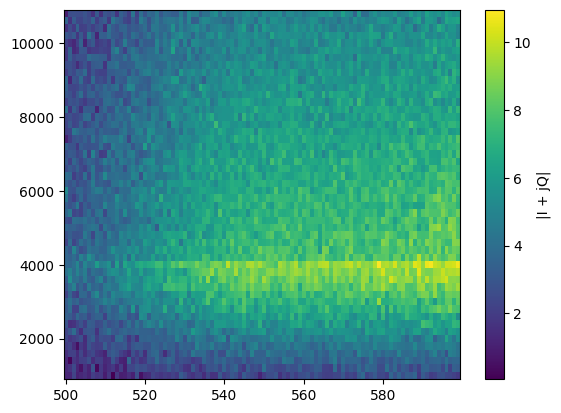

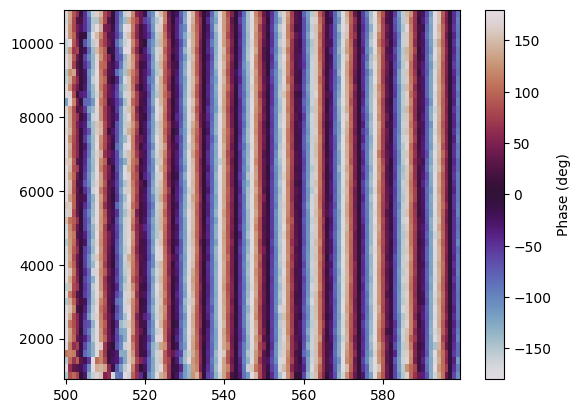

In [4]:
sc1 = plt.pcolormesh(freq, duration, avg, shading='nearest')
plt.colorbar(sc1, label="|I + jQ|")
plt.show()
phase = np.angle(np.array(avgi) + 1j * np.array(avgq), deg=True)
phase = np.reshape(phase, (int(cfg["expts"] / cfg["inner_loop"]), cfg["inner_loop"]))
sc2 = plt.pcolormesh(freq, duration, phase, shading='nearest', cmap='twilight')
plt.colorbar(sc2, label="Phase (deg)")
plt.show()